In [1]:
%matplotlib inline
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler, Imputer

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

from helper import *

/home/lizihaoleo/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
fi = pd.read_csv('./input/fi_fma.csv')
fi.head()

FileNotFoundError: File b'./input/fi_fma.csv' does not exist

In [14]:
importance_mean = fi.describe().loc['mean'][1]

In [8]:
fi_sorted = fi.sort_values('importance', ascending = False).reset_index()
fi_sorted['importance_normalized'] = fi_sorted['importance'] / fi_sorted['importance'].sum()
fi_sorted.head()

,level_0,index,feature,importance,importance_normalized
0,0,24,ORGANIZATION_TYPE,5504,0.057477
1,1,74,EXT_SOURCE_1,2304,0.024060
2,2,2,EXT_SOURCE_2,2298,0.023997
3,3,42,EXT_SOURCE_3,2298,0.023997
4,4,105,AMT_ANNUITY,1121,0.011706


In [16]:
selected_features = fi_sorted.loc[fi_sorted['importance'] >= importance_mean] # greater than average
selected_features = list(selected_features['feature'])
selected_features.append('SK_ID_CURR')

In [42]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

num_rows = None
prev_original = pd.read_csv('./input/previous_application.csv', nrows = num_rows)
prev, cat_cols = one_hot_encoder(prev_original, nan_as_category= True)
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean','sum']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})

prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

prev_cat = count_categorical(prev_original, group_var = 'SK_ID_CURR', df_name = 'PREV')

# Add feature: approved rate
prev_cat['APR_RATE'] = prev_cat['PREV_NAME_CONTRACT_STATUS_Approved_count'] / (prev_cat['PREV_NAME_CONTRACT_STATUS_Approved_count'] + prev_cat['PREV_NAME_CONTRACT_STATUS_Refused_count'])

prev_apr_rate_df = prev_cat[['APR_RATE']]

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

prev_agg = prev_agg.join(prev_apr_rate_df, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
gc.collect()

In [2]:
app_train = pd.read_csv('./application_train.csv')
app_test = pd.read_csv('./application_test.csv')

In [3]:
def standard_preprocess(app_train, app_test):
    """Standard preprocess of data, which include: 
    1. one-hoe encde
    2. data alignment
    3. fill up missing features with median value
    4. normalized features
    
    Parameters
    --------
        app_train (dataframe): 
            the training dataframe
        app_test (dataframe): 
            the testing dataframe
        
    Return
    --------
        app_train (dataframe): 
            the processed training dataframe
        app_test (dataframe): 
            the processed testing dataframe
    
    """
    # one-hot encoding of categorical variables
    app_train = pd.get_dummies(app_train)
    app_test = pd.get_dummies(app_test)
    
    print('Training Features shape after one-hoe enconding: ', app_train.shape)
    print('Testing Features shape after one-hoe enconding: ', app_test.shape)
    
    train_labels = app_train['TARGET']
    sk_id = app_train['SK_ID_CURR']
    
    # Align the training and testing data, keep only columns present in both dataframes
    app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

    # Add the target back in
    app_train['TARGET'] = train_labels

    print('Training Features shape after align: ', app_train.shape)
    print('Testing Features shape after align: ', app_test.shape)
    
    # do not treat the sk_id_curr
    sk_id_train = app_train['SK_ID_CURR']
    sk_id_test = app_test['SK_ID_CURR']

    app_train = app_train.drop(columns=['TARGET','SK_ID_CURR'])
    app_test = app_test.drop(columns=['SK_ID_CURR'])

    features = app_train.columns

    # Median imputation of missing values
    imputer = Imputer(strategy = 'median')

    # Scale each feature to 0-1
    scaler = MinMaxScaler(feature_range = (0, 1))

    # Fit on the training data
    imputer.fit(app_train)

    # Transform both training and testing data
    app_train = imputer.transform(app_train)
    app_test = imputer.transform(app_test)

    # Repeat with the scaler
    scaler.fit(app_train)
    app_train = scaler.transform(app_train)
    app_test = scaler.transform(app_test)
    
    app_train = pd.DataFrame(app_train,columns= features)
    app_train['TARGET'] = train_labels
    app_train['SK_ID_CURR'] = sk_id_train
    app_test = pd.DataFrame(app_test,columns= features)
    app_test['SK_ID_CURR'] = sk_id_test
    
    print('Final Training Features shape: ', app_train.shape)
    print('Final Testing Features shape: ', app_test.shape)    
    return app_train, app_test

In [4]:
app_train, app_test = standard_preprocess(app_train, app_test)

Training Features shape after one-hoe enconding:  (307511, 246)
Testing Features shape after one-hoe enconding:  (48744, 242)
Training Features shape after align:  (307511, 243)
Testing Features shape after align:  (48744, 242)
Final Training Features shape:  (307511, 243)
Final Testing Features shape:  (48744, 242)


In [5]:
app_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,SK_ID_CURR
0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,100002
1,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,100003
2,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100004
3,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100006
4,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,0.825268,0.519522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100007


In [6]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
missing_train = missing_values_table(app_train)
missing_train.head(10)

Your selected dataframe has 243 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [8]:
app_train.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,SK_ID_CURR
0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,0.045086,0.852140,0.705433,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,100002
1,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,0.043648,0.951929,0.959566,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,100003
2,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,0.046161,0.827335,0.648326,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100004
3,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,0.038817,0.601451,0.661387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100006
4,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,0.038820,0.825268,0.519522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,100007


In [9]:
app_test.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,SK_ID_CURR
0,0.000000,0.000935,0.130787,0.073886,0.102132,0.257000,0.337542,0.040670,0.790451,0.887175,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,100001
1,0.000000,0.000627,0.044387,0.061443,0.034792,0.491595,0.403890,0.035085,0.630431,0.774489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100005
2,0.000000,0.001512,0.154373,0.265830,0.147026,0.260475,0.292616,0.035114,0.911843,0.513269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100013
3,0.105263,0.002474,0.382022,0.184872,0.382716,0.361433,0.634329,0.041879,0.918936,0.415312,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,100028
4,0.052632,0.001320,0.144944,0.118761,0.145903,0.134897,0.687091,0.041030,0.837873,0.407809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100038


In [10]:
missing_train = missing_values_table(app_train)
missing_train.head(10)

Your selected dataframe has 243 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Aggregating Numeric Columns
To account for the numeric information in the bureau dataframe, we can compute statistics for all the numeric columns. To do so, we groupby the client id, agg the grouped dataframe, and merge the result back into the training data. The agg function will only calculate the values for the numeric columns where the operation is considered valid. We will stick to using 'mean', 'max', 'min', 'sum' but any function can be passed in here. We can even write our own function and use it in an agg call.

In [11]:
# encapsulate all of the previous work into a function
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(col, axis = 1)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes(include = ['number'])
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

### Categorical Variables
First, we will use the counting the number of categorical type in each category for each client.

Then, we can normalize these value counts by the total number of occurences of that categorical variable for that observation (meaning that the normalized counts must sum to 1.0 for each observation).

One-hot encode a dataframe with only the categorical columns (dtype == 'object').

In [12]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes(include = ['object']))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

### Breau dataset
 - All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
 - For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

For the numerical features, we will find the numeric stats.

For categorical features, we will have one-hot-encode first, then find out counts and normalized counts.
 

In [13]:
bureau = pd.read_csv('./bureau.csv')
bureau_balance = pd.read_csv('./bureau_balance.csv')

In [14]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [15]:
bureau_agg = agg_numeric(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


### Bureau Balance dataset
We will process the bureau balance dataframe. This dataframe has monthly information about each client's previous loan(s) with other financial institutions. Instead of grouping this dataframe by the SK_ID_CURR which is the client id, we will first group the dataframe by the SK_ID_BUREAU which is the id of the previous loan. This will give us one row of the dataframe for each loan. Then, we can group by the SK_ID_CURR and calculate the aggregations across the loans of each client. The final result will be a dataframe with one row for each client, with stats calculated for their loans.

To recap, for the bureau_balance dataframe we:

1. Calculated numeric stats grouping by each loan
2. Made value counts of each categorical variable grouping by loan
3. Merged the stats and the value counts on the loans
4. Calculated numeric stats for the resulting dataframe grouping by the client id

The final resulting dataframe has one row for each client, with statistics calculated for all of their loans with monthly balance information.

In [16]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [17]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


In [18]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan, group_var = 'SK_ID_CURR', df_name = 'client')

In [19]:
original_features = list(app_train.columns)
print('Original Number of Features: ', len(original_features))

Original Number of Features:  243


Lastly, merge all preprocessed data into one dataframe.

For the train data:

In [20]:
# Merge with the value counts of bureau
app_train = app_train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
app_train = app_train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
app_train = app_train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [21]:
new_features = list(app_train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Number of features using previous loans from other institutions data:  454


In [22]:
missing_train = missing_values_table(app_train)
missing_train.head(10)

Your selected dataframe has 454 columns.
There are 211 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_ANNUITY_mean,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_min,227502,74.0
client_bureau_balance_STATUS_2_count_min,215280,70.0
client_bureau_balance_STATUS_0_count_norm_mean,215280,70.0
client_bureau_balance_STATUS_0_count_norm_min,215280,70.0
client_bureau_balance_STATUS_1_count_mean,215280,70.0
client_bureau_balance_STATUS_1_count_max,215280,70.0
client_bureau_balance_STATUS_1_count_min,215280,70.0
client_bureau_balance_STATUS_1_count_norm_mean,215280,70.0


Same for the test data.

In [23]:
# Merge with the value counts of bureau
app_test = app_test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
app_test = app_test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
app_test = app_test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [24]:
print('Shape of Testing Data: ', app_test.shape)

Shape of Testing Data:  (48744, 453)


In [25]:
train_labels = app_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Data Shape: ', app_train.shape)
print('Testing Data Shape: ', app_test.shape)

Training Data Shape:  (307511, 454)
Testing Data Shape:  (48744, 453)


In [26]:
missing_test = missing_values_table(app_test)
missing_test.head(10)

Your selected dataframe has 453 columns.
There are 211 columns that have missing values.


,Missing Values,% of Total Values
bureau_AMT_CREDIT_MAX_OVERDUE_min,19659,40.3
bureau_AMT_CREDIT_MAX_OVERDUE_max,19659,40.3
bureau_AMT_CREDIT_MAX_OVERDUE_mean,19659,40.3
bureau_DAYS_ENDDATE_FACT_mean,10944,22.5
bureau_DAYS_ENDDATE_FACT_min,10944,22.5
bureau_DAYS_ENDDATE_FACT_max,10944,22.5
bureau_AMT_CREDIT_SUM_LIMIT_mean,10683,21.9
bureau_AMT_CREDIT_SUM_LIMIT_min,10683,21.9
bureau_AMT_CREDIT_SUM_LIMIT_max,10683,21.9
bureau_AMT_ANNUITY_min,10529,21.6


In [27]:
app_train.to_csv('./preprocessed_data/train_bureau_raw.csv', index = False)
app_test.to_csv('./preprocessed_data/test_bureau_raw.csv', index = False)

In [2]:
app_train = pd.read_csv('./preprocessed_data/train_bureau_raw.csv')
app_test = pd.read_csv('./preprocessed_data/test_bureau_raw.csv')

In [28]:
# Free up memory by deleting old objects
import gc
gc.enable()
del bureau, bureau_balance, bureau_agg, bureau_balance_agg, \
bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

154

### previous_application.csv

 - All previous applications for Home Credit loans of clients who have loans in our sample.
 - There is one row for each previous application related to loans in our data sample.

In [3]:
prev = pd.read_csv('./previous_application.csv')
prev.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)

In [5]:
# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [6]:
# # one-hot encoding of categorical variables
# prev = pd.get_dummies(prev)

# print('Features shape after one-hoe enconding: ', prev.shape)

In [7]:
missing_prev = missing_values_table(prev)
missing_prev.head(10)

Your selected dataframe has 38 columns.
There are 17 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
DAYS_FIRST_DRAWING,1607509,96.2
DAYS_TERMINATION,898978,53.8
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
DAYS_LAST_DUE,884286,52.9
NAME_TYPE_SUITE,820405,49.1
DAYS_LAST_DUE_1ST_VERSION,766929,45.9
DAYS_FIRST_DUE,713710,42.7


In [8]:
prev_agg = agg_numeric(prev, group_var = 'SK_ID_CURR', df_name = 'prev')
prev_agg.head()

,SK_ID_CURR,prev_AMT_ANNUITY_count,prev_AMT_ANNUITY_mean,prev_AMT_ANNUITY_max,prev_AMT_ANNUITY_min,prev_AMT_ANNUITY_sum,prev_AMT_APPLICATION_count,prev_AMT_APPLICATION_mean,prev_AMT_APPLICATION_max,prev_AMT_APPLICATION_min,...,prev_NFLAG_INSURED_ON_APPROVAL_count,prev_NFLAG_INSURED_ON_APPROVAL_mean,prev_NFLAG_INSURED_ON_APPROVAL_max,prev_NFLAG_INSURED_ON_APPROVAL_min,prev_NFLAG_INSURED_ON_APPROVAL_sum,prev_APP_CREDIT_PERC_count,prev_APP_CREDIT_PERC_mean,prev_APP_CREDIT_PERC_max,prev_APP_CREDIT_PERC_min,prev_APP_CREDIT_PERC_sum
0,100001,1,3951.000,3951.000,3951.000,3951.000,1,24835.50,24835.5,24835.5,...,1,0.000000,0.0,0.0,0.0,1,1.044079,1.044079,1.044079,1.044079
1,100002,1,9251.775,9251.775,9251.775,9251.775,1,179055.00,179055.0,179055.0,...,1,0.000000,0.0,0.0,0.0,1,1.000000,1.000000,1.000000,1.000000
2,100003,3,56553.990,98356.995,6737.310,169661.970,3,435436.50,900000.0,68809.5,...,3,0.666667,1.0,0.0,2.0,3,0.949329,1.011109,0.868825,2.847988
3,100004,1,5357.250,5357.250,5357.250,5357.250,1,24282.00,24282.0,24282.0,...,1,0.000000,0.0,0.0,0.0,1,1.207699,1.207699,1.207699,1.207699
4,100005,1,4813.200,4813.200,4813.200,4813.200,2,22308.75,44617.5,0.0,...,1,0.000000,0.0,0.0,0.0,1,1.111173,1.111173,1.111173,1.111173


In [9]:
prev_cat = count_categorical(prev, group_var = 'SK_ID_CURR', df_name = 'prev')
prev_cat.head()

,prev_NAME_CONTRACT_TYPE_Cash loans_count,prev_NAME_CONTRACT_TYPE_Cash loans_count_norm,prev_NAME_CONTRACT_TYPE_Consumer loans_count,prev_NAME_CONTRACT_TYPE_Consumer loans_count_norm,prev_NAME_CONTRACT_TYPE_Revolving loans_count,prev_NAME_CONTRACT_TYPE_Revolving loans_count_norm,prev_NAME_CONTRACT_TYPE_XNA_count,prev_NAME_CONTRACT_TYPE_XNA_count_norm,prev_WEEKDAY_APPR_PROCESS_START_FRIDAY_count,prev_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm,...,prev_PRODUCT_COMBINATION_POS industry without interest_count,prev_PRODUCT_COMBINATION_POS industry without interest_count_norm,prev_PRODUCT_COMBINATION_POS mobile with interest_count,prev_PRODUCT_COMBINATION_POS mobile with interest_count_norm,prev_PRODUCT_COMBINATION_POS mobile without interest_count,prev_PRODUCT_COMBINATION_POS mobile without interest_count_norm,prev_PRODUCT_COMBINATION_POS other with interest_count,prev_PRODUCT_COMBINATION_POS other with interest_count_norm,prev_PRODUCT_COMBINATION_POS others without interest_count,prev_PRODUCT_COMBINATION_POS others without interest_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,1,1.0,0,0.0,0,0.0,0,0.0
100002,0,0.000000,1,1.000000,0,0.0,0,0.0,0,0.000000,...,0,0.0,0,0.0,0,0.0,1,1.0,0,0.0
100003,1,0.333333,2,0.666667,0,0.0,0,0.0,1,0.333333,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,1,1.000000,0,0.0,0,0.0,1,1.000000,...,0,0.0,0,0.0,1,1.0,0,0.0,0,0.0
100005,1,0.500000,1,0.500000,0,0.0,0,0.0,1,0.500000,...,0,0.0,1,0.5,0,0.0,0,0.0,0,0.0


In [10]:
list(prev_cat.columns)

['prev_NAME_CONTRACT_TYPE_Cash loans_count',
 'prev_NAME_CONTRACT_TYPE_Cash loans_count_norm',
 'prev_NAME_CONTRACT_TYPE_Consumer loans_count',
 'prev_NAME_CONTRACT_TYPE_Consumer loans_count_norm',
 'prev_NAME_CONTRACT_TYPE_Revolving loans_count',
 'prev_NAME_CONTRACT_TYPE_Revolving loans_count_norm',
 'prev_NAME_CONTRACT_TYPE_XNA_count',
 'prev_NAME_CONTRACT_TYPE_XNA_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_FRIDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_FRIDAY_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_MONDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_MONDAY_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_SATURDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_SATURDAY_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_SUNDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_SUNDAY_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_THURSDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_THURSDAY_count_norm',
 'prev_WEEKDAY_APPR_PROCESS_START_TUESDAY_count',
 'prev_WEEKDAY_APPR_PROCESS_START_TUESDAY_c

In [11]:
# Add feature: approved percentage
prev_cat['apv_percent'] = prev_cat['prev_NAME_CONTRACT_STATUS_Approved_count'] / (prev_cat['prev_NAME_CONTRACT_STATUS_Approved_count'] + prev_cat['prev_NAME_CONTRACT_STATUS_Refused_count'])

In [12]:
# Merge with the value counts of previous
app_train = app_train.merge(prev_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of previous
app_train = app_train.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of previous
app_test = app_test.merge(prev_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of previous
app_test = app_test.merge(prev_agg, on = 'SK_ID_CURR', how = 'left')


In [13]:
train_labels = app_train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Data Shape: ', app_train.shape)
print('Testing Data Shape: ', app_test.shape)

Training Data Shape:  (307511, 841)
Testing Data Shape:  (48744, 840)


In [14]:
app_train.to_csv('./preprocessed_data/train_bureau_prev_raw.csv', index = False)
app_test.to_csv('./preprocessed_data/test_bureau_prev_raw.csv', index = False)

del prev, prev_agg, prev_cat
gc.collect()

77

In [2]:
app_train = pd.read_csv('./preprocessed_data/train_bureau_prev_raw.csv')
app_test = pd.read_csv('./preprocessed_data/test_bureau_prev_raw.csv')

print('Training Data Shape: ', app_train.shape)
print('Testing Data Shape: ', app_test.shape)

Training Data Shape:  (307511, 841)
Testing Data Shape:  (48744, 840)


data = original data + bureau + bureau balance + previous application

In [3]:
submission, fi, metrics = lgb_model(app_train, app_test)

Training Data Shape:  (307511, 839)
Testing Data Shape:  (48744, 839)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.776824	train's auc: 0.825407
[400]	valid's auc: 0.777362	train's auc: 0.861083
Early stopping, best iteration is:
[305]	valid's auc: 0.777624	train's auc: 0.845727
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.780831	train's auc: 0.824017
[400]	valid's auc: 0.782161	train's auc: 0.860576
Early stopping, best iteration is:
[368]	valid's auc: 0.782257	train's auc: 0.855719
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.771933	train's auc: 0.826095
[400]	valid's auc: 0.773209	train's auc: 0.861934
Early stopping, best iteration is:
[363]	valid's auc: 0.773384	train's auc: 0.856039
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.777973	train's auc: 0.824521
[400]	valid's auc: 0.778596	train's auc: 0.861387
Early stopping, best it

In [4]:
metrics

,fold,train,valid
0,0,0.845727,0.777624
1,1,0.855719,0.782257
2,2,0.856039,0.773384
3,3,0.852785,0.778812
4,4,0.844789,0.780179
5,overall,0.851012,0.778418


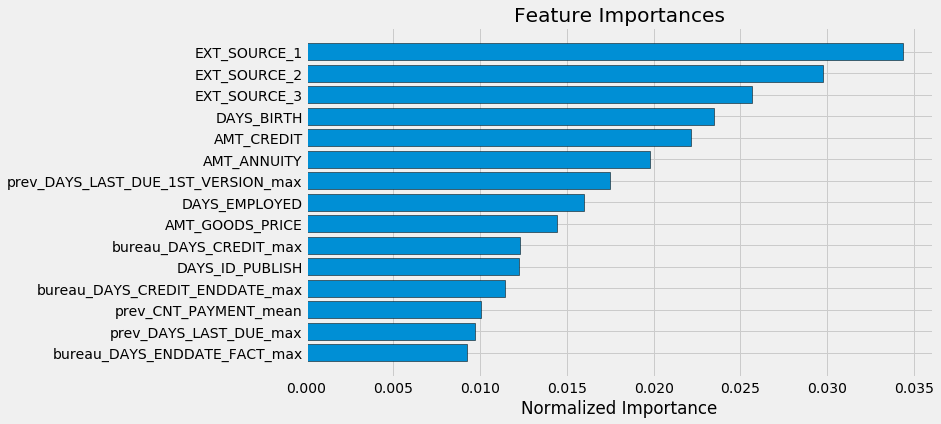

In [5]:
fi_sorted = plot_feature_importances(fi)

In [7]:
submission.to_csv('./model_performance/bureau_prev.csv', index = False)

In [8]:
train_corr_removed, test_corr_removed = remove_cor(app_train, app_test)

Number of columns to remove:  255
Training Corrs Removed Shape:  (307511, 586)
Testing Corrs Removed Shape:  (48744, 585)


In [9]:
submission_corr_removed, fi_corr_removed, metrics_corr_removed = lgb_model(train_corr_removed, test_corr_removed)

Training Data Shape:  (307511, 584)
Testing Data Shape:  (48744, 584)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.774917	train's auc: 0.821096
Early stopping, best iteration is:
[293]	valid's auc: 0.775505	train's auc: 0.838614
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.778593	train's auc: 0.820211
[400]	valid's auc: 0.779258	train's auc: 0.855487
Early stopping, best iteration is:
[342]	valid's auc: 0.779749	train's auc: 0.846353
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.767943	train's auc: 0.821744
[400]	valid's auc: 0.768778	train's auc: 0.856745
Early stopping, best iteration is:
[352]	valid's auc: 0.769131	train's auc: 0.849408
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.775349	train's auc: 0.820764
Early stopping, best iteration is:
[297]	valid's auc: 0.775995	train's auc: 0.839624
Training until validation scores don't

In [10]:
metrics_corr_removed

,fold,train,valid
0,0,0.838614,0.775505
1,1,0.846353,0.779749
2,2,0.849408,0.769131
3,3,0.839624,0.775995
4,4,0.852221,0.778375
5,overall,0.845244,0.775715


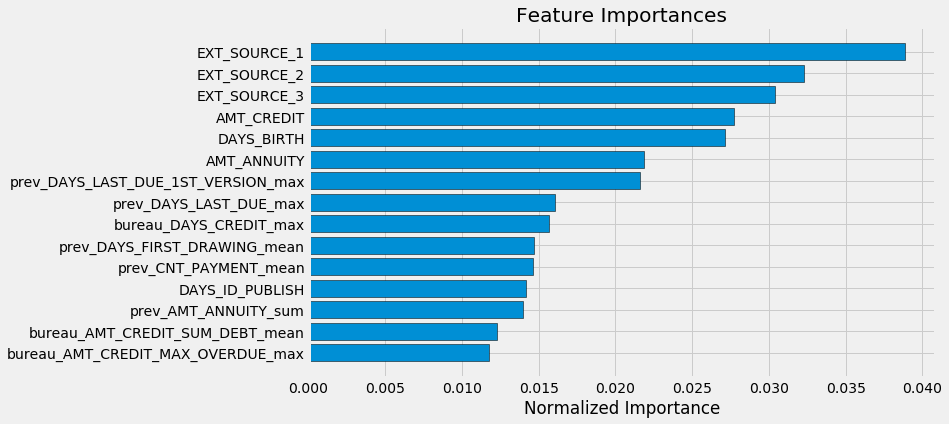

In [11]:
fi_sorted_corr_removed = plot_feature_importances(fi_corr_removed)

In [12]:
del train_corr_removed, test_corr_removed
gc.collect()

11291

### Installments_payments.csv

- Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
- There is a) one row for every payment that was made plus b) one row each for missed payment.
- One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [13]:
ins = pd.read_csv('./installments_payments.csv')

In [14]:
# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

In [15]:
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)

In [17]:
ins_agg = agg_numeric(ins, group_var = 'SK_ID_CURR', df_name = 'install')
ins_agg.head()

,SK_ID_CURR,install_NUM_INSTALMENT_VERSION_count,install_NUM_INSTALMENT_VERSION_mean,install_NUM_INSTALMENT_VERSION_max,install_NUM_INSTALMENT_VERSION_min,install_NUM_INSTALMENT_VERSION_sum,install_NUM_INSTALMENT_NUMBER_count,install_NUM_INSTALMENT_NUMBER_mean,install_NUM_INSTALMENT_NUMBER_max,install_NUM_INSTALMENT_NUMBER_min,...,install_DPD_count,install_DPD_mean,install_DPD_max,install_DPD_min,install_DPD_sum,install_DBD_count,install_DBD_mean,install_DBD_max,install_DBD_min,install_DBD_sum
0,100001,7,1.142857,2.0,1.0,8.0,7,2.714286,4,1,...,7,1.571429,11.0,0.0,11.0,7,8.857143,36.0,0.0,62.0
1,100002,19,1.052632,2.0,1.0,20.0,19,10.000000,19,1,...,19,0.000000,0.0,0.0,0.0,19,20.421053,31.0,12.0,388.0
2,100003,25,1.040000,2.0,1.0,26.0,25,5.080000,12,1,...,25,0.000000,0.0,0.0,0.0,25,7.160000,14.0,1.0,179.0
3,100004,3,1.333333,2.0,1.0,4.0,3,2.000000,3,1,...,3,0.000000,0.0,0.0,0.0,3,7.666667,11.0,3.0,23.0
4,100005,9,1.111111,2.0,1.0,10.0,9,5.000000,9,1,...,9,0.111111,1.0,0.0,1.0,9,23.666667,37.0,0.0,213.0


In [18]:
# Count installments accounts
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

del ins
gc.collect()

3292

In [19]:
# Merge with the value counts of install payment
app_train = app_train.merge(ins_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of install payment
app_test = app_test.merge(ins_agg, on = 'SK_ID_CURR', how = 'left')

In [24]:
app_train.to_csv('./preprocessed_data/train_bureau_prev_ins_raw.csv', index = False)
app_test.to_csv('./preprocessed_data/test_bureau_prev_ins_raw.csv', index = False)

In [2]:
app_train = pd.read_csv('./preprocessed_data/train_bureau_prev_ins_raw.csv')
app_test = pd.read_csv('./preprocessed_data/test_bureau_prev_ins_raw.csv')

In [3]:
submission, fi, metrics = lgb_model(app_train, app_test)

Training Data Shape:  (307511, 890)
Testing Data Shape:  (48744, 890)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782193	train's auc: 0.83077
[400]	valid's auc: 0.78334	train's auc: 0.866912
Early stopping, best iteration is:
[329]	valid's auc: 0.783673	train's auc: 0.855467
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786104	train's auc: 0.829481
[400]	valid's auc: 0.788068	train's auc: 0.866291
Early stopping, best iteration is:
[433]	valid's auc: 0.78815	train's auc: 0.871493
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.778149	train's auc: 0.831085
[400]	valid's auc: 0.779657	train's auc: 0.86771
Early stopping, best iteration is:
[489]	valid's auc: 0.779856	train's auc: 0.880355
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.782582	train's auc: 0.830305
Early stopping, best iteration is:
[278]	valid's auc: 0.783596	train's auc: 0

In [4]:
metrics

,fold,train,valid
0,0,0.855467,0.783673
1,1,0.871493,0.788150
2,2,0.880355,0.779856
3,3,0.846067,0.783596
4,4,0.847432,0.785674
5,overall,0.860163,0.783998


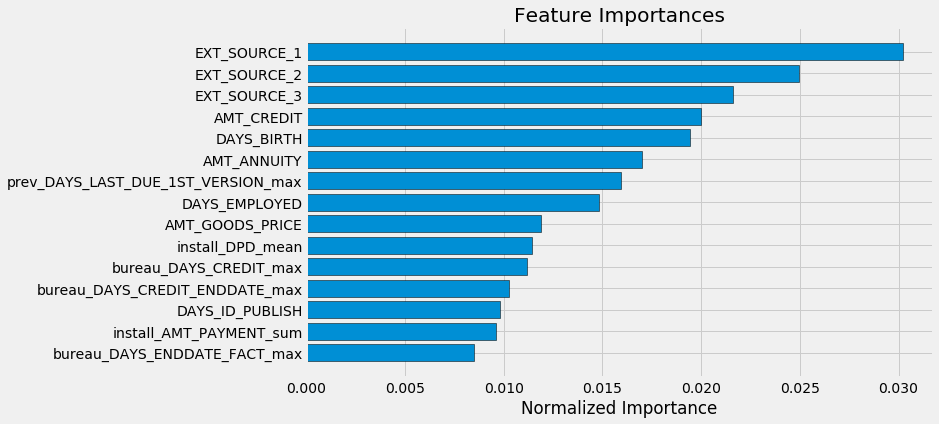

In [5]:
fi_sorted = plot_feature_importances(fi)

In [26]:
submission.to_csv('./model_performance/bureau_prev_ins.csv', index = False)

In [6]:
train_zero_removed, test_zero_removed = drop_fi_zero_imp(app_train, app_test ,fi_sorted)

Before drop zero importance cloumns training shape:  (307511, 892)
Before drop zero importance cloumns testing shape:  (48744, 891)
Drop  211  Column(s)
After drop zero importance cloumns training shape:  (307511, 681)
After drop zero importance cloumns testing shape:  (48744, 680)


In [7]:
train_zero_removed.to_csv('./preprocessed_data/train_bureau_prev_ins_removed.csv', index = False)
test_zero_removed.to_csv('./preprocessed_data/test_bureau_prev_ins_removed.csv', index = False)

### credit_card_balance.csv

- Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
- This table has one row for each month of history of every previous credit in Home -Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [16]:
cc = pd.read_csv('./credit_card_balance.csv')
cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
cc_agg = agg_numeric(cc, group_var = 'SK_ID_CURR', df_name = 'cc')
cc_agg.head()

,SK_ID_CURR,cc_MONTHS_BALANCE_count,cc_MONTHS_BALANCE_mean,cc_MONTHS_BALANCE_max,cc_MONTHS_BALANCE_min,cc_MONTHS_BALANCE_sum,cc_AMT_BALANCE_count,cc_AMT_BALANCE_mean,cc_AMT_BALANCE_max,cc_AMT_BALANCE_min,...,cc_SK_DPD_count,cc_SK_DPD_mean,cc_SK_DPD_max,cc_SK_DPD_min,cc_SK_DPD_sum,cc_SK_DPD_DEF_count,cc_SK_DPD_DEF_mean,cc_SK_DPD_DEF_max,cc_SK_DPD_DEF_min,cc_SK_DPD_DEF_sum
0,100006,6,-3.5,-1,-6,-21,6,0.000000,0.00,0.0,...,6,0.000000,0,0,0,6,0.000000,0,0,0
1,100011,74,-38.5,-2,-75,-2849,74,54482.111149,189000.00,0.0,...,74,0.000000,0,0,0,74,0.000000,0,0,0
2,100013,96,-48.5,-1,-96,-4656,96,18159.919219,161420.22,0.0,...,96,0.010417,1,0,1,96,0.010417,1,0,1
3,100021,17,-10.0,-2,-18,-170,17,0.000000,0.00,0.0,...,17,0.000000,0,0,0,17,0.000000,0,0,0
4,100023,8,-7.5,-4,-11,-60,8,0.000000,0.00,0.0,...,8,0.000000,0,0,0,8,0.000000,0,0,0


In [17]:
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [18]:
del cc
gc.collect()

77

In [19]:
# Merge with the value counts of install payment
train_zero_removed = train_zero_removed.merge(cc_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of install payment
test_zero_removed = test_zero_removed.merge(cc_agg, on = 'SK_ID_CURR', how = 'left')

print(train_zero_removed.shape)
print(test_zero_removed.shape)

(307511, 782)
(48744, 781)


In [20]:
train_zero_removed.to_csv('./preprocessed_data/train_bureau_prev_ins_cc_raw.csv', index = False)
test_zero_removed.to_csv('./preprocessed_data/test_bureau_prev_ins_cc_raw.csv', index = False)

In [21]:
submission, fi, metrics = lgb_model(train_zero_removed, test_zero_removed)

Training Data Shape:  (307511, 780)
Testing Data Shape:  (48744, 780)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.78323	train's auc: 0.831808
[400]	valid's auc: 0.78399	train's auc: 0.867926
Early stopping, best iteration is:
[322]	valid's auc: 0.784328	train's auc: 0.855458
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.785826	train's auc: 0.830652
[400]	valid's auc: 0.78712	train's auc: 0.867658
Early stopping, best iteration is:
[335]	valid's auc: 0.787413	train's auc: 0.857068
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779925	train's auc: 0.832717
[400]	valid's auc: 0.781531	train's auc: 0.869185
Early stopping, best iteration is:
[358]	valid's auc: 0.781703	train's auc: 0.862522
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784009	train's auc: 0.831243
[400]	valid's auc: 0.784899	train's auc: 0.868145
Early stopping, best itera

In [22]:
metrics

,fold,train,valid
0,0,0.855458,0.784328
1,1,0.857068,0.787413
2,2,0.862522,0.781703
3,3,0.863681,0.785044
4,4,0.860503,0.787680
5,overall,0.859846,0.785212


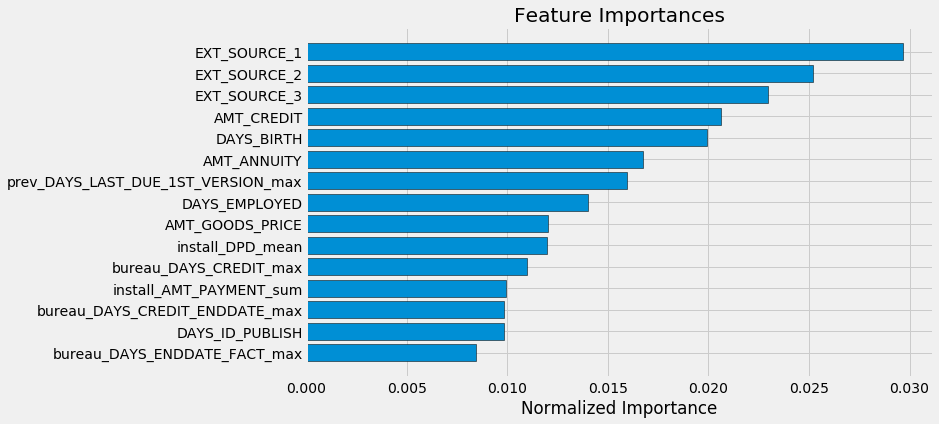

In [23]:
fi_sorted = plot_feature_importances(fi)

In [24]:
submission.to_csv('./model_performance/bureau_prev_ins_cc.csv', index = False)

In [25]:
train_zero_removed, test_zero_removed = \
drop_fi_zero_imp(train_zero_removed, test_zero_removed ,fi_sorted)

Before drop zero importance cloumns training shape:  (307511, 782)
Before drop zero importance cloumns testing shape:  (48744, 781)
Drop  58  Column(s)
After drop zero importance cloumns training shape:  (307511, 724)
After drop zero importance cloumns testing shape:  (48744, 723)


### POS_CASH_balance.csv

- Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
- This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [27]:
pos = pd.read_csv('./POS_CASH_balance.csv')
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [28]:
pos_agg = agg_numeric(pos, group_var = 'SK_ID_CURR', df_name = 'pos')
pos_agg.head()

,SK_ID_CURR,pos_MONTHS_BALANCE_count,pos_MONTHS_BALANCE_mean,pos_MONTHS_BALANCE_max,pos_MONTHS_BALANCE_min,pos_MONTHS_BALANCE_sum,pos_CNT_INSTALMENT_count,pos_CNT_INSTALMENT_mean,pos_CNT_INSTALMENT_max,pos_CNT_INSTALMENT_min,...,pos_SK_DPD_count,pos_SK_DPD_mean,pos_SK_DPD_max,pos_SK_DPD_min,pos_SK_DPD_sum,pos_SK_DPD_DEF_count,pos_SK_DPD_DEF_mean,pos_SK_DPD_DEF_max,pos_SK_DPD_DEF_min,pos_SK_DPD_DEF_sum
0,100001,9,-72.555556,-53,-96,-653,9,4.000000,4.0,4.0,...,9,0.777778,7,0,7,9,0.777778,7,0,7
1,100002,19,-10.000000,-1,-19,-190,19,24.000000,24.0,24.0,...,19,0.000000,0,0,0,19,0.000000,0,0,0
2,100003,28,-43.785714,-18,-77,-1226,28,10.107143,12.0,6.0,...,28,0.000000,0,0,0,28,0.000000,0,0,0
3,100004,4,-25.500000,-24,-27,-102,4,3.750000,4.0,3.0,...,4,0.000000,0,0,0,4,0.000000,0,0,0
4,100005,11,-20.000000,-15,-25,-220,10,11.700000,12.0,9.0,...,11,0.000000,0,0,0,11,0.000000,0,0,0


In [29]:
pos_cat = count_categorical(pos, group_var = 'SK_ID_CURR', df_name = 'pos')
pos_cat.head()

,pos_NAME_CONTRACT_STATUS_Active_count,pos_NAME_CONTRACT_STATUS_Active_count_norm,pos_NAME_CONTRACT_STATUS_Amortized debt_count,pos_NAME_CONTRACT_STATUS_Amortized debt_count_norm,pos_NAME_CONTRACT_STATUS_Approved_count,pos_NAME_CONTRACT_STATUS_Approved_count_norm,pos_NAME_CONTRACT_STATUS_Canceled_count,pos_NAME_CONTRACT_STATUS_Canceled_count_norm,pos_NAME_CONTRACT_STATUS_Completed_count,pos_NAME_CONTRACT_STATUS_Completed_count_norm,pos_NAME_CONTRACT_STATUS_Demand_count,pos_NAME_CONTRACT_STATUS_Demand_count_norm,pos_NAME_CONTRACT_STATUS_Returned to the store_count,pos_NAME_CONTRACT_STATUS_Returned to the store_count_norm,pos_NAME_CONTRACT_STATUS_Signed_count,pos_NAME_CONTRACT_STATUS_Signed_count_norm,pos_NAME_CONTRACT_STATUS_XNA_count,pos_NAME_CONTRACT_STATUS_XNA_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,7.0,0.777778,0,0.0,0,0.0,0,0.0,2,0.222222,0,0.0,0,0.0,0,0.000000,0,0.0
100002,19.0,1.000000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
100003,26.0,0.928571,0,0.0,0,0.0,0,0.0,2,0.071429,0,0.0,0,0.0,0,0.000000,0,0.0
100004,3.0,0.750000,0,0.0,0,0.0,0,0.0,1,0.250000,0,0.0,0,0.0,0,0.000000,0,0.0
100005,9.0,0.818182,0,0.0,0,0.0,0,0.0,1,0.090909,0,0.0,0,0.0,1,0.090909,0,0.0


In [30]:
# Merge with the value counts of pos cash
train_zero_removed = train_zero_removed.merge(pos_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of pos cash
train_zero_removed = train_zero_removed.merge(pos_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of pos cash
test_zero_removed = test_zero_removed.merge(pos_cat, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of pos cash
test_zero_removed = test_zero_removed.merge(pos_agg, on = 'SK_ID_CURR', how = 'left')

del pos, pos_agg, pos_cat
gc.collect()

2794

In [31]:
print('Training Data Shape: ', train_zero_removed.shape)
print('Testing Data Shape: ', test_zero_removed.shape)

Training Data Shape:  (307511, 767)
Testing Data Shape:  (48744, 766)


In [32]:
submission, fi, metrics = lgb_model(train_zero_removed, test_zero_removed)

Training Data Shape:  (307511, 765)
Testing Data Shape:  (48744, 765)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783301	train's auc: 0.832221
Early stopping, best iteration is:
[269]	valid's auc: 0.784299	train's auc: 0.846219
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786675	train's auc: 0.831438
[400]	valid's auc: 0.787739	train's auc: 0.868155
Early stopping, best iteration is:
[358]	valid's auc: 0.788127	train's auc: 0.861504
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779412	train's auc: 0.83282
[400]	valid's auc: 0.781098	train's auc: 0.869591
Early stopping, best iteration is:
[337]	valid's auc: 0.781254	train's auc: 0.859231
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784271	train's auc: 0.831623
[400]	valid's auc: 0.785118	train's auc: 0.868469
Early stopping, best iteration is:
[349]	valid's auc: 0.785453	train's auc

In [33]:
metrics

,fold,train,valid
0,0,0.846219,0.784299
1,1,0.861504,0.788127
2,2,0.859231,0.781254
3,3,0.860469,0.785453
4,4,0.861574,0.786357
5,overall,0.857799,0.785058


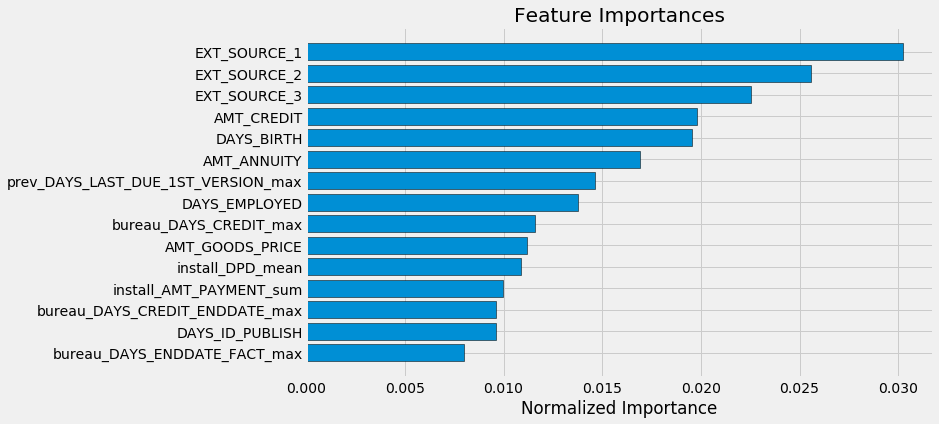

In [34]:
fi_sorted = plot_feature_importances(fi)

In [35]:
submission.to_csv('./model_performance/all_data_pred.csv', index = False)

In [36]:
train_zero_removed, test_zero_removed = \
drop_fi_zero_imp(train_zero_removed, test_zero_removed ,fi_sorted)

Before drop zero importance cloumns training shape:  (307511, 767)
Before drop zero importance cloumns testing shape:  (48744, 766)
Drop  30  Column(s)
After drop zero importance cloumns training shape:  (307511, 737)
After drop zero importance cloumns testing shape:  (48744, 736)


In [37]:
submission, fi, metrics = lgb_model(train_zero_removed, test_zero_removed)

Training Data Shape:  (307511, 735)
Testing Data Shape:  (48744, 735)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.783301	train's auc: 0.832221
Early stopping, best iteration is:
[269]	valid's auc: 0.784299	train's auc: 0.846219
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.786675	train's auc: 0.831438
[400]	valid's auc: 0.787739	train's auc: 0.868155
Early stopping, best iteration is:
[358]	valid's auc: 0.788127	train's auc: 0.861504
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.779412	train's auc: 0.83282
[400]	valid's auc: 0.780969	train's auc: 0.869603
Early stopping, best iteration is:
[337]	valid's auc: 0.781254	train's auc: 0.859231
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.784271	train's auc: 0.831623
[400]	valid's auc: 0.785201	train's auc: 0.868619
Early stopping, best iteration is:
[380]	valid's auc: 0.785464	train's auc

In [38]:
metrics

,fold,train,valid
0,0,0.846219,0.784299
1,1,0.861504,0.788127
2,2,0.859231,0.781254
3,3,0.865473,0.785464
4,4,0.861574,0.786357
5,overall,0.858800,0.785052


In [2]:
valid2 = pd.read_csv('./model_performance/valid_v2.csv')
valid3 = pd.read_csv('./model_performance/valid_v3.csv')
print(valid2.shape, valid3.shape)

(307511, 2) (307511, 2)


In [3]:
stack = pd.DataFrame(data={'v2':valid2['pred'],'v3':valid3['pred'],'target':valid2['Target']})

In [47]:
# stack[stack > 0.5] = 1
# stack[stack <= 0.5] = 0
# stack.head()

,v2,v3,target
0,1.0,1.0,1.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,1.0,0.0


In [4]:
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
X = stack[['v2','v3']]
y = stack['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [13]:
columns = []
for i in range(10):
    column = ('%.1fv1_%.1fv2'%(i*.1, 1-i*.1))
    columns.append(column)
    stack[column] = i*.1*stack['v2'] + (1-i*.1)*stack['v3']
    
stack.head()

,v2,v3,target,0.0v1_1.0v2,0.1v1_0.9v2,0.2v1_0.8v2,0.3v1_0.7v2,0.4v1_0.6v2,0.5v1_0.5v2,0.6v1_0.4v2,0.7v1_0.3v2,0.8v1_0.2v2,0.9v1_0.1v2
0,0.807798,0.790778,1.0,0.790778,0.792480,0.794182,0.795884,0.797586,0.799288,0.800990,0.802692,0.804394,0.806096
1,0.139536,0.206629,0.0,0.206629,0.199919,0.193210,0.186501,0.179791,0.173082,0.166373,0.159664,0.152954,0.146245
2,0.352291,0.322144,0.0,0.322144,0.325159,0.328174,0.331188,0.334203,0.337218,0.340233,0.343247,0.346262,0.349277
3,0.235172,0.276383,0.0,0.276383,0.272262,0.268140,0.264019,0.259898,0.255777,0.251656,0.247535,0.243414,0.239293
4,0.487555,0.512544,0.0,0.512544,0.510045,0.507546,0.505047,0.502548,0.500049,0.497550,0.495051,0.492553,0.490054


In [19]:
result = {}
for column in columns:
    pred = stack[column]
    result[column] = metrics.roc_auc_score(stack['target'], pred)
result

{'0.0v1_1.0v2': 0.7884438022853977,
 '0.1v1_0.9v2': 0.7898117247424485,
 '0.2v1_0.8v2': 0.7909401056398989,
 '0.3v1_0.7v2': 0.791819979194121,
 '0.4v1_0.6v2': 0.7924442456228001,
 '0.5v1_0.5v2': 0.7928081248561357,
 '0.6v1_0.4v2': 0.7929085232791215,
 '0.7v1_0.3v2': 0.7927453291739245,
 '0.8v1_0.2v2': 0.7923188567469509,
 '0.9v1_0.1v2': 0.7916339078700789}

In [22]:
sorted(result.items(), key=lambda x: x[1], reverse= True)

[('0.6v1_0.4v2', 0.7929085232791215),
 ('0.5v1_0.5v2', 0.7928081248561357),
 ('0.7v1_0.3v2', 0.7927453291739245),
 ('0.4v1_0.6v2', 0.7924442456228001),
 ('0.8v1_0.2v2', 0.7923188567469509),
 ('0.3v1_0.7v2', 0.791819979194121),
 ('0.9v1_0.1v2', 0.7916339078700789),
 ('0.2v1_0.8v2', 0.7909401056398989),
 ('0.1v1_0.9v2', 0.7898117247424485),
 ('0.0v1_1.0v2', 0.7884438022853977)]

In [58]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LinearRegression()
scoring = 'roc_auc'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.792


In [65]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
print("ROC AUC error: %.4f"
      % metrics.roc_auc_score(y_test, y_pred))

Coefficients: 
 [0.22514807 0.15928765]
ROC AUC error: 0.7946


In [23]:
v2 = pd.read_csv('./model_performance/v2.csv')
v3 = pd.read_csv('./model_performance/v3_pred_0.788.csv')
v2.head()

,SK_ID_CURR,TARGET
0,100001,0.242517
1,100005,0.550138
2,100013,0.198297
3,100028,0.247584
4,100038,0.649602


In [24]:
v3.head()

,SK_ID_CURR,TARGET
0,100001,0.241929
1,100005,0.672702
2,100013,0.220181
3,100028,0.275804
4,100038,0.688642


In [25]:
stack_model_pd = pd.DataFrame(data={'SK_ID_CURR':v2['SK_ID_CURR'],'v2':v2['TARGET'],'v3':v3['TARGET']})
stack_model_pd.head()

,SK_ID_CURR,v2,v3
0,100001,0.242517,0.241929
1,100005,0.550138,0.672702
2,100013,0.198297,0.220181
3,100028,0.247584,0.275804
4,100038,0.649602,0.688642


In [26]:
throushould = .6
stack_model_pd['TARGET'] = throushould*stack_model_pd['v2'] + (1-throushould)*stack_model_pd['v3']
stack_model_pd.head()

,SK_ID_CURR,v2,v3,stacking
0,100001,0.242517,0.241929,0.242282
1,100005,0.550138,0.672702,0.599163
2,100013,0.198297,0.220181,0.207051
3,100028,0.247584,0.275804,0.258872
4,100038,0.649602,0.688642,0.665218


In [29]:
stack_model_pd = stack_model_pd.drop(['v2','v3'],axis=1)
stack_model_pd.head()

,SK_ID_CURR,stacking
0,100001,0.242282
1,100005,0.599163
2,100013,0.207051
3,100028,0.258872
4,100038,0.665218


In [31]:
stack_model_pd.to_csv('./model_performance/v2_v3_stack.csv',index=False)

In [71]:
regr = LinearRegression()
regr.fit(X, y)
print('Coefficients: \n', regr.coef_)
pred = regr.predict(stack_model_pd[['v2','v3']])
pred = pd.DataFrame(pred)

Coefficients: 
 [0.22136677 0.16210011]


In [72]:
pred.head()

,0
0,0.036694
1,0.174619
2,0.023380
3,0.043307
4,0.199221
